In [210]:
# import libraries
import praw
import pandas as pd
import re
import nltk
import folium
import spacy
import matplotlib.pyplot as plt
import contractions
import numpy as np
import seaborn as sns
import pandas as pd
import spacy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.tokenize import TweetTokenizer
from geopy.geocoders import Nominatim
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from folium.plugins import HeatMap, MarkerCluster

# Download NLTK stopwords list 
nltk.download('stopwords', quiet=True)

True

## TASK 1 :  Social Media Data Extraction & Preprocessing (API Handling & Text Cleaning)

In [2]:
# create a Reddit instance using PRAW (Python Reddit API Wrapper)
reddit = praw.Reddit(client_id='pvwKdrxl39aQ-RJy4D-DXA',
                     client_secret='y4dV9-91CnJO1OYNWcNGJdV1mnOGaQ',
                     user_agent='detect crisis')

subreddits = [
    'mentalhealth', 'depression', 'SuicideWatch', 'anxiety',
    'addiction', 'stress', 'traumatoolbox', 'BPD', 'CPTSD'
]

# Keyword Setup – list of crisis-related terms/phrases to search for
keywords = [
    "depressed", "suicidal", "overwhelmed", "relapse", "addiction help",
    "self harm", "unwanted life", "end it all", "no way out", "anxiety attack",
    "hopeless", "need help","end life","terminate life","death wish","want to die",
    "stress", 'anxiety', 'mental health', 'therapy'
]

# Combine keywords into a single query string (phrases in quotes) for PRAW search
query = " OR ".join([f'"{term}"' if " " in term else term for term in keywords])

# Data Retrieval – search Reddit posts containing any of the keywords (in all subreddits)
posts = []
for sub in subreddits:
    for post in reddit.subreddit(sub).search(query=query, sort = "new", limit=1000):
        # Only consider textual posts (skip if no selftext and short title, or if it's a link)
        text_content = post.title + " " + (post.selftext or "")
        if text_content.strip() == "":
            continue  # skip posts without any text content

        posts.append({
            "post_id": post.id,
            "timestamp": pd.to_datetime(post.created_utc, unit='s'),  # convert Unix epoch to datetime
            "content": text_content,
            "score": post.score,      # upvotes - downvotes 
            "num_comments": post.num_comments,
            "subreddit": post.subreddit.display_name
        })


# Load posts into DataFrame
df = pd.DataFrame(posts)
print(f"Retrieved {len(df)} posts related to the crisis keywords.")
# Save the cleaned dataset to CSV
df.to_csv("posts.csv", index=False)
print("Data saved to posts.csv")


Retrieved 1976 posts related to the crisis keywords.
Data saved to posts.csv


In [107]:
df_posts = pd.read_csv("posts.csv")
df_posts.value_counts("subreddit")

subreddit
Anxiety          250
BPD              250
depression       250
mentalhealth     250
SuicideWatch     249
CPTSD            247
Stress           246
traumatoolbox    234
Name: count, dtype: int64

In [108]:
df_posts

,post_id,timestamp,content,score,num_comments,subreddit
0,1jsefuu,2025-04-05 21:41:03,I can not handle any (platonic) love I have al...,1,1,mentalhealth
1,1jse55r,2025-04-05 21:27:10,Hypochondriac with a history of MDD and GAD I ...,1,0,mentalhealth
2,1jse0ev,2025-04-05 21:21:05,Im tired of letting my mental health affect my...,2,2,mentalhealth
3,1jsdyer,2025-04-05 21:18:33,Depression that comes and goes a few times a y...,1,2,mentalhealth
4,1jsdw4s,2025-04-05 21:15:41,"My gf is always angry with me, and I dont know...",1,6,mentalhealth
...,...,...,...,...,...,...
1971,1jo96jq,2025-03-31 17:43:18,Does anyone else constantly feel obligated to ...,37,8,CPTSD
1972,1jo90tj,2025-03-31 17:36:58,DAE freak the f out at medical tests? I freak ...,4,4,CPTSD
1973,1jo8zpa,2025-03-31 17:35:43,Finding Core Content I do not remember a lot o...,0,2,CPTSD
1974,1jo82my,2025-03-31 16:59:07,Feeling doomed of relationships I have always ...,6,1,CPTSD


In [109]:
# Text Cleaning – remove noise for NLP processing

stop_words = set(stopwords.words('english'))

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

tokenizer = TweetTokenizer()

# Define regex pattern for emojis (unicode ranges)
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def clean_text(text):
    text = contractions.fix(text)  # Expand contractions: "don’t" → "do not"
    text = text.lower()    # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)    # Remove URLs
    text = remove_emojis(text)    # Remove emojis
    
    words = tokenizer.tokenize(text)  # Better for informal social media text
    
    # Customize stopword list to keep negations
    negations = {"not", "no", "nor", "n't", "never"}
    custom_stopwords = set(stopwords.words('english')) - negations

    # Remove stopwords and non-alphabetic tokens, but preserve important terms
    words = [word for word in words if word.isalpha() and word not in custom_stopwords]

    cleaned_text = ' '.join(words)
    
    return cleaned_text


In [110]:
# Apply text cleaning to content of each post
df_posts['clean_content'] = df_posts['content'].apply(clean_text)
df_posts.head()

,post_id,timestamp,content,score,num_comments,subreddit,clean_content
0,1jsefuu,2025-04-05 21:41:03,I can not handle any (platonic) love I have al...,1,1,mentalhealth,not handle platonic love always struggled maki...
1,1jse55r,2025-04-05 21:27:10,Hypochondriac with a history of MDD and GAD I ...,1,0,mentalhealth,hypochondriac history mdd gad tried cymbalta s...
2,1jse0ev,2025-04-05 21:21:05,Im tired of letting my mental health affect my...,2,2,mentalhealth,tired letting mental health affect appetite mo...
3,1jsdyer,2025-04-05 21:18:33,Depression that comes and goes a few times a y...,1,2,mentalhealth,depression comes goes times year lasting longe...
4,1jsdw4s,2025-04-05 21:15:41,"My gf is always angry with me, and I dont know...",1,6,mentalhealth,gf always angry not know handle ir anymore dev...


In [111]:
df_posts[['content', 'clean_content']].head(20)

,content,clean_content
0,I can not handle any (platonic) love I have al...,not handle platonic love always struggled maki...
1,Hypochondriac with a history of MDD and GAD I ...,hypochondriac history mdd gad tried cymbalta s...
2,Im tired of letting my mental health affect my...,tired letting mental health affect appetite mo...
3,Depression that comes and goes a few times a y...,depression comes goes times year lasting longe...
4,"My gf is always angry with me, and I dont know...",gf always angry not know handle ir anymore dev...
5,bro I NEED to stop being jealous 💔🥀 ok so cont...,bro need stop jealous ok content warning eatin...
6,Please help me!!! Recently I'm feeling lonely ...,please help recently feeling lonely lot though...
7,Do i have something to worrie about my mental ...,something worrie mental health hi strugling lo...
8,Writings on Happiness: Hope for the Hopeless T...,writings happiness hope hopeless always one mo...
9,Feeling grateful I have been meditating a lot ...,feeling grateful meditating lot lately felt mo...


## Task 2: Sentiment & Crisis Risk Classification (NLP & Text Processing)

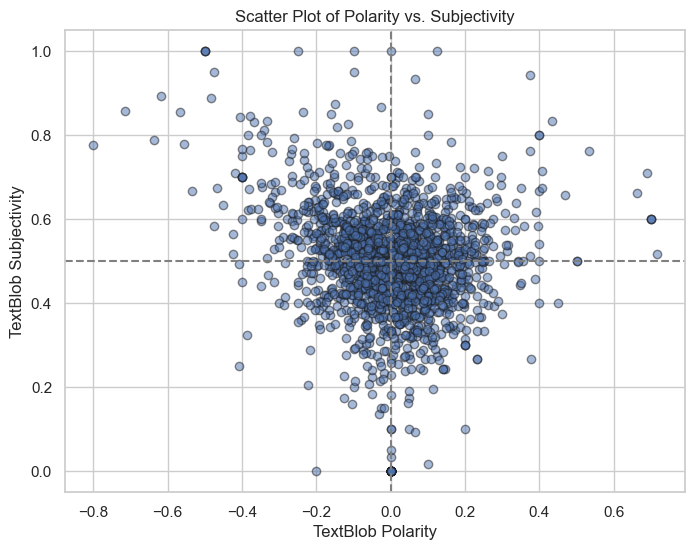

In [113]:
# Sentiment Analysis using TextBlob

# Function that returns both polarity and subjectivity
def get_polarity_subjectivity(text):
    polarities = []
    subjectivities = []
    blob = TextBlob(text)
    blob = blob.correct()   # correct spelling errors
    polarities = blob.sentiment.polarity  # float in [-1.0, 1.0]
    subjectivities = blob.sentiment.subjectivity  # float in [0.0, 1.0]
    return polarities, subjectivities

df_posts['polarity'], df_posts['subjectivity'] = zip(*df_posts['clean_content'].apply(get_polarity_subjectivity))

# Separate Positive/Negative/Neutral label, define that logic using polarity
def get_sentiment_label(polarity):
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df_posts['sentiment'] = df_posts['polarity'].apply(get_sentiment_label)

# Plot a scatter plot of polarity (x-axis) vs subjectivity (y-axis)
plt.figure(figsize=(8, 6))
plt.scatter(df_posts['polarity'], df_posts['subjectivity'], alpha=0.5, edgecolors='k')
plt.axvline(x=0, color='gray', linestyle='--')    # vertical reference at polarity=0
plt.axhline(y=0.5, color='gray', linestyle='--')  # horizontal reference at y=0.5
plt.xlabel("TextBlob Polarity")
plt.ylabel("TextBlob Subjectivity")
plt.title("Scatter Plot of Polarity vs. Subjectivity")
plt.show()


Sentiment Distribution:
sentiment
Neutral     1139
Positive     421
Negative     416
Name: count, dtype: int64


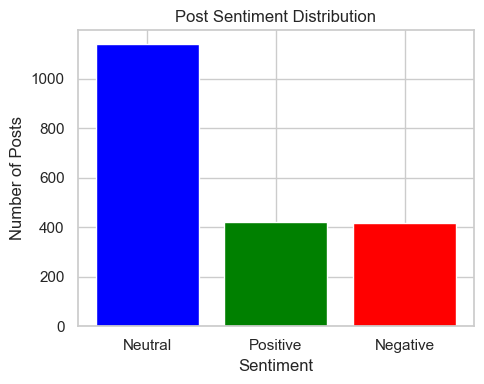

In [114]:
# Sentiment Distribution – count posts per sentiment
sentiment_counts = df_posts['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)


# Visualization: Plot bar charts for sentiment distribution
plt.figure(figsize=(5,4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue','green','red'])
plt.title("Post Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.savefig("sentiment_distribution_plot.png")

### Clustering

In [115]:
# Prepare features from TF-IDF
features = tfidf.transform(df_posts['clean_content']).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names_out())

# Reduce dimensions 
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features_df)

# check how much variance is preserved
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance preserved:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.0206646  0.01069955]
Total variance preserved: 0.0313641539458584


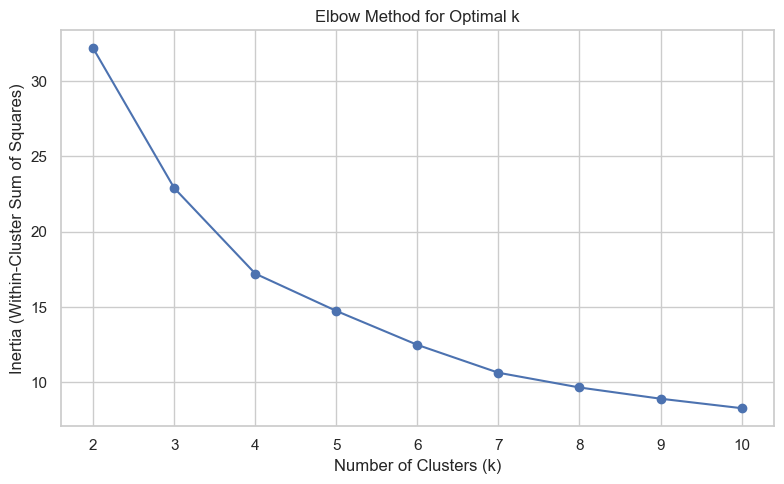

In [116]:
# Finding optimal number of clusters using the Elbow Method

# Try k values from 2 to 10
inertias = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.tight_layout()
plt.show()


KMeans Silhouette Score: 0.39031184654040696


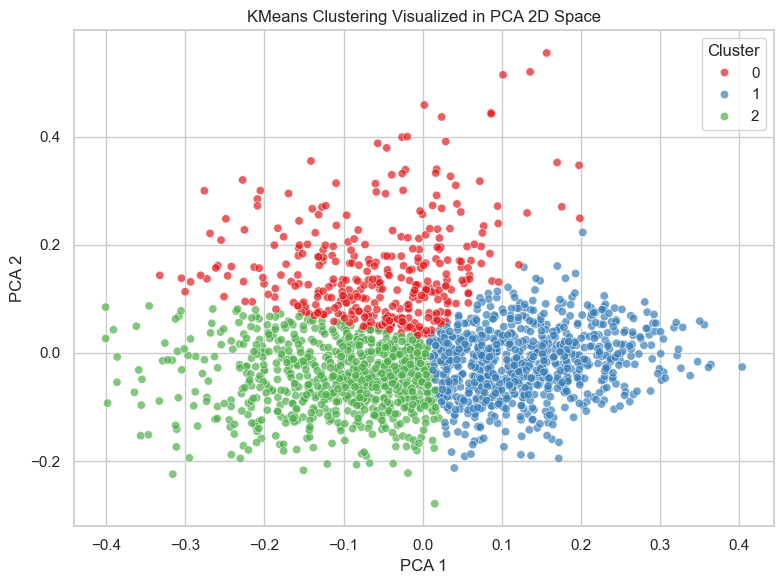

In [121]:
# Unsupervised clustering - KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)
df_posts['cluster'] =  cluster_labels

print("KMeans Silhouette Score:", silhouette_score(reduced_features,  cluster_labels))

df_viz = df_posts.copy()
df_viz['pca1'] = reduced_features[:, 0]
df_viz['pca2'] = reduced_features[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz, x='pca1', y='pca2', hue='cluster', palette='Set1', alpha=0.7)
plt.title("KMeans Clustering Visualized in PCA 2D Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [185]:
for cluster_id in np.unique(cluster_labels):
    cluster_docs = features_df[cluster_labels == cluster_id]
    avg_tfidf = cluster_docs.mean(axis=0)
    top_indices = np.argsort(avg_tfidf)[::-1][:10]
    top_words = [features_df.columns[i] for i in top_indices]
    print(f"Cluster {cluster_id} top terms:", top_words)

Cluster 0 top terms: ['not', 'want', 'life', 'cannot', 'die', 'like', 'feel', 'know', 'not want', 'tired']
Cluster 1 top terms: ['anxiety', 'not', 'stress', 'anyone', 'like', 'help', 'feel', 'get', 'would', 'health']
Cluster 2 top terms: ['not', 'like', 'feel', 'know', 'would', 'even', 'really', 'get', 'time', 'life']


In [136]:
# Review Sentiment Distribution Per Cluster

cluster_sentiment = df_posts.groupby('cluster')['sentiment'].value_counts().unstack().fillna(0)
cluster_sentiment['total'] = cluster_sentiment.sum(axis=1)
cluster_sentiment['percent_negative'] = (cluster_sentiment['Negative'] / cluster_sentiment['total']) * 100
cluster_sentiment['percent_neutral'] = (cluster_sentiment['Neutral'] / cluster_sentiment['total']) * 100
cluster_sentiment['percent_positive'] = (cluster_sentiment['Positive'] / cluster_sentiment['total']) * 100

cluster_sentiment[['total','Negative', 'Neutral', 'Positive', 'percent_negative', 'percent_neutral', 'percent_positive']]


sentiment,total,Negative,Neutral,Positive,percent_negative,percent_neutral,percent_positive
cluster,,,,,,,
0,364,140,170,54,38.461538,46.703297,14.835165
1,810,167,404,239,20.617284,49.876543,29.506173
2,802,109,565,128,13.591022,70.448878,15.960100


- Cluster 0 has the highest negative sentiment and lowest positivity → likely contains posts with crisis signals.
- Cluster 1 is a middle ground — more positivity, but still meaningful negative.
- Cluster 2 is mostly neutral and calm, indicating general discussion.

In [128]:
cluster_to_risk = {
    0: 'High Concern',
    1: 'Moderate Concern',
    2: 'Low Concern'
}
df_posts['risk_from_cluster'] = df_posts['cluster'].map(cluster_to_risk)


cluster_risk
Low Risk         1265
Moderate Risk     404
High Risk         307
Name: count, dtype: int64


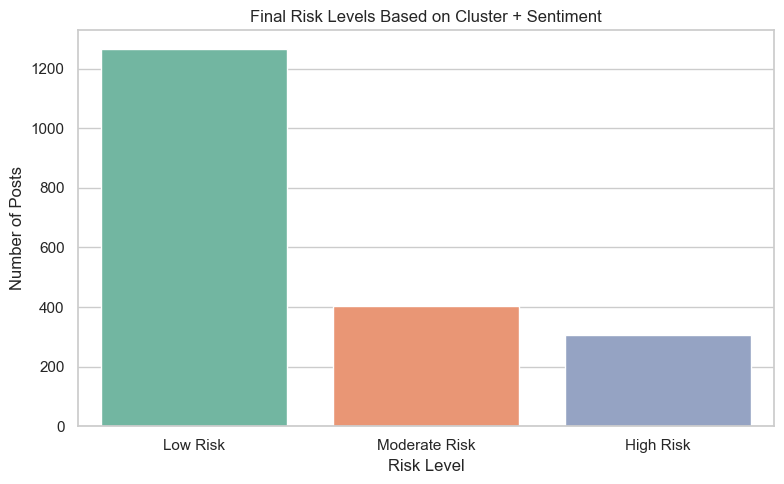

In [170]:
# hybrid risk assessment by combining sentiment and cluster

def hybrid_risk_assessment(row):
    if row['sentiment'] == 'Negative' and row['risk_from_cluster'] in ['High Concern', 'Moderate Concern']:
        return 'High Risk'
    elif row['sentiment'] == 'Neutral' and row['risk_from_cluster'] == 'Moderate Concern':
        return 'Moderate Risk'
    else:
        return 'Low Risk'
df_posts['cluster_risk'] = df_posts.apply(hybrid_risk_assessment, axis=1)

print(df_posts['cluster_risk'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df_posts, x='cluster_risk', hue = 'cluster_risk',palette='Set2')
plt.title("Final Risk Levels Based on Cluster + Sentiment")
plt.xlabel("Risk Level")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

## Supervised Classification

In [166]:
# Risk Level Classification(considering only neutral and negative) 
# based on Risk Keyword Matching + Scoring (Rule-based) + sentiment

CRISIS_KEYWORDS = {
    'high': [
        'suicidal', 'kill myself', 'end it all', 'want to die',
        'end my life', 'death wish', 'terminate life', 'no reason to live',
        'give up on life', 'life is not worth living', 'tired of living',
        'i hate living'
    ],
    'moderate': [
        'depressed', 'overwhelmed', 'panic attack', 'cant cope',
        'relapse', 'self harm', 'unwanted life', 'no way out',
        'feel hopeless', 'no hope', 'feel lost', 'so alone',
        'very alone', 'struggling', 'cant sleep', 'tired of life',
        'heartbroken', 'worthless'
    ],
    'low': [
        'stress', 'anxiety', 'mental health', 'therapy',
        'anxiety attack', 'hopeless', 'need help', 'help me',
        'upset', 'sad', 'anxious', 'lonely'
    ]
}

# TF-IDF Feature Setup
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3), lowercase=True)
tfidf_matrix = tfidf.fit_transform(df_posts['clean_content'])
feature_names = tfidf.get_feature_names_out()


#  TF-IDF Based Scoring
def assess_risk_with_tfidf(tfidf_matrix, feature_names, sentiments):
    risk_scores = []
    for idx, doc in enumerate(tfidf_matrix):
        sentiment = sentiments[idx]
        if sentiment == "Positive":
            risk_scores.append(0)
            continue
        
        score = 0
        for i in range(len(doc.indices)):
            word = feature_names[doc.indices[i]].lower()
            weight = doc.data[i]
            if word in CRISIS_KEYWORDS['high']:
                score += weight * 3
            elif word in CRISIS_KEYWORDS['moderate']:
                score += weight * 2
            elif word in CRISIS_KEYWORDS['low']:
                score += weight * 1
        risk_scores.append(score)
    
    max_score = max(risk_scores) if risk_scores else 1
    return [score / max_score for score in risk_scores]  # normalized score (0 to 1)

df_posts['tfidf_risk_score'] = assess_risk_with_tfidf(tfidf_matrix, feature_names, df_posts['sentiment'].tolist())


# Keyword-Based Risk Detection (Substring Search)
def keyword_match_risk(text):
    text = text.lower()
    for phrase in CRISIS_KEYWORDS['high']:
        if phrase in text:
            return 'High Concern'
    for phrase in CRISIS_KEYWORDS['moderate']:
        if phrase in text:
            return 'Moderate Concern'
    for phrase in CRISIS_KEYWORDS['low']:
        if phrase in text:
            return 'Low Concern'
    return 'Low Concern'

df_posts['keyword_risk'] = df_posts.apply(
    lambda row: keyword_match_risk(row['clean_content']) if row['sentiment'] != 'Positive' else 'Low Concern',
    axis=1
)

# Combine Logic
def final_risk_decision(score, keyword_risk, sentiment):
    if sentiment == "Positive":
        return "Low Concern"
    if keyword_risk == "High Concern" or score >= 0.3:
        return "High Concern"
    elif keyword_risk == "Moderate Concern" or score >= 0.1:
        return "Moderate Concern"
    else:
        return "Low Concern"

df_posts['risk_level'] = df_posts.apply(
    lambda row: final_risk_decision(row['tfidf_risk_score'], row['keyword_risk'], row['sentiment']),
    axis=1
)

In [167]:
# Review Sentiment Distribution

keyword_sentiment = df_posts.groupby('risk_level')['sentiment'].value_counts().unstack().fillna(0)
keyword_sentiment['total'] = keyword_sentiment.sum(axis=1)
keyword_sentiment['percent_negative'] = (keyword_sentiment['Negative'] / keyword_sentiment['total']) * 100
keyword_sentiment['percent_neutral'] = (keyword_sentiment['Neutral'] / keyword_sentiment['total']) * 100
keyword_sentiment['percent_positive'] = (keyword_sentiment['Positive'] / keyword_sentiment['total']) * 100

keyword_sentiment[['total','Negative', 'Neutral', 'Positive', 'percent_negative', 'percent_neutral', 'percent_positive']]

sentiment,total,Negative,Neutral,Positive,percent_negative,percent_neutral,percent_positive
risk_level,,,,,,,
High Concern,190.0,44.0,146.0,0.0,23.157895,76.842105,0.000000
Low Concern,1164.0,212.0,531.0,421.0,18.213058,45.618557,36.168385
Moderate Concern,622.0,160.0,462.0,0.0,25.723473,74.276527,0.000000


In [151]:
# Convert risk level labels to numerical values
risk_label_mapping = {
    'High Concern': 2,
    'Moderate Concern': 1,
    'Low Concern': 0
}
df_posts['risk_label'] = df_posts['risk_level'].map(risk_label_mapping)

# Drop rows with missing labels
df_new = df_posts.dropna(subset=['risk_label'])

# Prepare features from TF-IDF
features = tfidf.transform(df_new['clean_content']).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names_out())

# Split original data first
X_train, X_test, y_train, y_test = train_test_split(features_df, df_new['risk_label'], test_size=0.2, random_state=42)

# Then oversample only training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("After oversampling:", Counter(y_train_resampled))

After oversampling: Counter({1: 925, 0: 925, 2: 925})


In [157]:
# Train Random Forest with balanced class weights
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,               # Cap tree depth
    min_samples_split=20,       # Require more samples per split
    min_samples_leaf=5,         # Require more samples per leaf
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

# Print classification results
print("Random Forest Classification Report with RandomOverSampler:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report with RandomOverSampler:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       239
           1       0.71      0.58      0.64       112
           2       0.95      0.89      0.92        45

    accuracy                           0.80       396
   macro avg       0.82      0.79      0.80       396
weighted avg       0.80      0.80      0.80       396



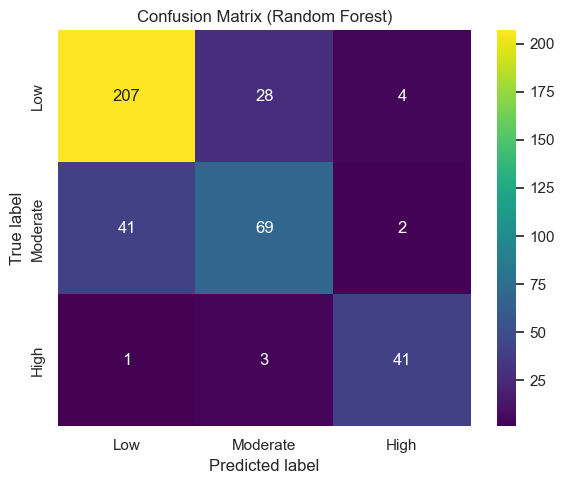

In [180]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True, 
            xticklabels=['Low', 'Moderate', 'High'],
            yticklabels=['Low', 'Moderate', 'High'],
            linewidths=0)  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()


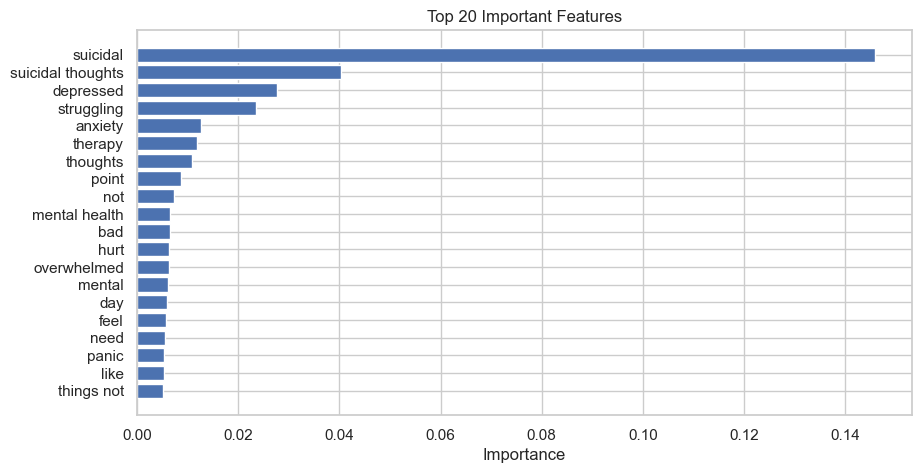

In [161]:
# Feature Importance using Random Forest

importances = rf.feature_importances_
indices = importances.argsort()[::-1][:20]
top_features = [features_df.columns[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Top 20 Important Features")
plt.barh(top_features[::-1], importances[indices][::-1])
plt.xlabel("Importance")
plt.show()


The model relies heavily on emotionally charged and clinically significant terms such as suicidal, depressed, and struggling, demonstrating high alignment with known crisis indicators. This suggests the classifier can effectively prioritize posts for mental health triage or support escalation

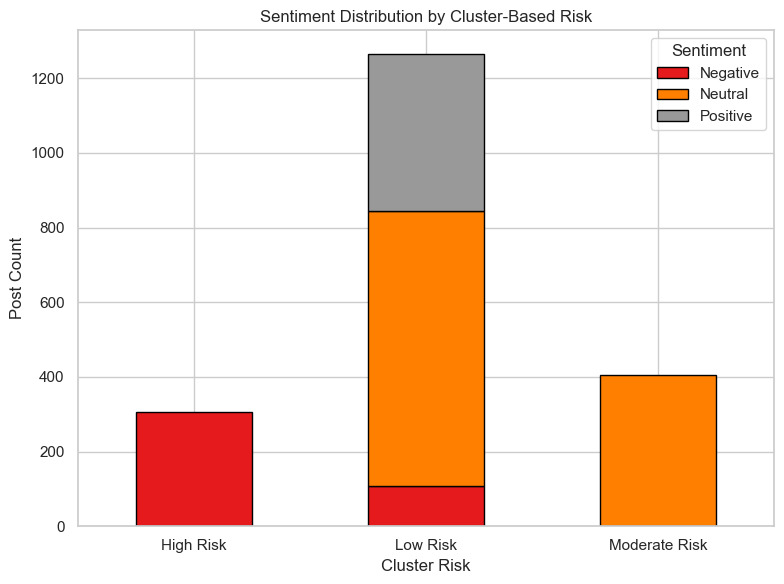

In [204]:
# Cluster-based risk per sentiment
cluster_sentiment = (
    df_posts.groupby(['cluster_risk', 'sentiment'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_risk', columns='sentiment', values='count')
    .fillna(0)
)

cluster_sentiment[['Negative', 'Neutral', 'Positive']].plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    colormap='Set1',
    edgecolor='black'
)

plt.title("Sentiment Distribution by Cluster-Based Risk")
plt.xlabel("Cluster Risk")
plt.ylabel("Post Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


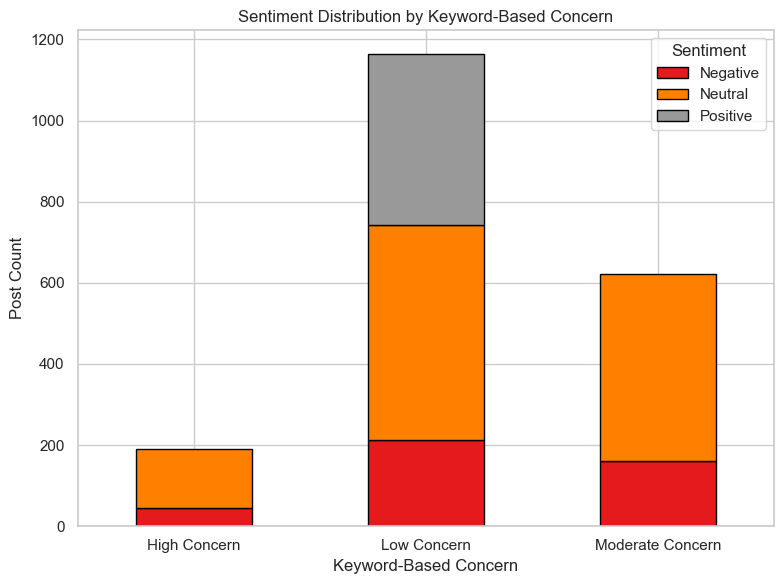

In [203]:
# Keyword-based risk per sentiment
concern_sentiment = (
    df_posts.groupby(['risk_level', 'sentiment'])
    .size()
    .reset_index(name='count')
    .pivot(index='risk_level', columns='sentiment', values='count')
    .fillna(0)
)

concern_sentiment[['Negative', 'Neutral', 'Positive']].plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    colormap='Set1',
    edgecolor='black'
)

plt.title("Sentiment Distribution by Keyword-Based Concern")
plt.xlabel("Keyword-Based Concern")
plt.ylabel("Post Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Task 3: Crisis Geolocation & Mapping (Basic Geospatial Analysis & Visualization)

geographic hotspots by risk severity, useful for targeted intervention

In [211]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Filter posts with High or Moderate concern
filtered_df = df_posts[df_posts['risk_level'].isin(['High Concern', 'Moderate Concern'])].copy()
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])  # Ensure timestamp is datetime

# Geocoding setup
geolocator = Nominatim(user_agent="crisis_app")
locations_coords = []        # For heatmap
marker_data = []             # For marker map
location_counts = {}         # For top 5 frequency
location_risk_counts = defaultdict(lambda: {'High Concern': 0, 'Moderate Concern': 0})
location_time_pairs = []     # For time-location mapping

# Extract valid locations and geocode
for idx, row in filtered_df.iterrows():
    doc = nlp(row['clean_content'])
    for ent in doc.ents:
        if ent.label_ in ['GPE', 'LOC']:
            place = ent.text.strip()
            try:
                location = geolocator.geocode(place)
                if location and location.raw.get('type') in ['city', 'administrative', 'state', 'country']:
                    lat, lon = location.latitude, location.longitude
                    locations_coords.append([lat, lon])
                    marker_data.append((lat, lon, place.title(), row['risk_level']))
                    key = place.title()
                    location_counts[key] = location_counts.get(key, 0) + 1
                    location_risk_counts[key][row['risk_level']] += 1
                    location_time_pairs.append((row['timestamp'].date(), key))
            except:
                continue

# Print Top 5 Locations
if location_counts:
    top5 = sorted(location_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nNumber of unique valid locations found:", len(location_counts))
    print("\nTop 5 mentioned locations (with post counts):")
    for place, count in top5:
        print(f"{place}: {count} posts")
else:
    print("No valid geocoded locations found.")

# Risk breakdown
print("\nLocation-wise Risk Breakdown:")
for loc, risks in location_risk_counts.items():
    total = risks['High Concern'] + risks['Moderate Concern']
    if total > 0:
        print(f"{loc}: High={risks['High Concern']}, Moderate={risks['Moderate Concern']}")


Number of unique valid locations found: 34

Top 5 mentioned locations (with post counts):
Us: 6 posts
California: 5 posts
Colorado: 3 posts
Germany: 2 posts
Spain: 2 posts

Location-wise Risk Breakdown:
Michigan: High=1, Moderate=0
Colorado: High=1, Moderate=2
Germany: High=2, Moderate=0
Chicago: High=0, Moderate=1
Uk: High=0, Moderate=1
London: High=0, Moderate=1
Earth: High=1, Moderate=0
California: High=5, Moderate=0
Moscow: High=1, Moderate=0
South Africa: High=0, Moderate=1
America: High=1, Moderate=0
Florida: High=1, Moderate=0
Spain: High=0, Moderate=2
Detroit: High=0, Moderate=1
Mexico: High=0, Moderate=2
United States: High=0, Moderate=1
Us: High=5, Moderate=1
Virginia: High=2, Moderate=0
Santa Cruz Area: High=1, Moderate=0
North Carolina: High=1, Moderate=0
Oakland: High=2, Moderate=0
West Coast: High=1, Moderate=0
Australia: High=0, Moderate=1
Las Vegas: High=0, Moderate=1
Denver: High=0, Moderate=1
Washington: High=0, Moderate=1
Canada: High=1, Moderate=0
Missouri: High=0,

In [237]:
# Folium Heatmap
if locations_coords:
    avg_lat = sum([lat for lat, _ in locations_coords]) / len(locations_coords)
    avg_lon = sum([lon for _, lon in locations_coords]) / len(locations_coords)

    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)
    HeatMap(locations_coords, radius=8).add_to(m)
    m.save("crisis_locations_heatmap.html")
    print("\n Heatmap saved to: crisis_locations_heatmap.html")
else:
    print(" No location data available for heatmap.")



 Heatmap saved to: crisis_locations_heatmap.html


In [253]:
m

In addition to the heatmap, add markers with popups showing location + number of posts

In [238]:
# Marker Cluster Map
if marker_data:
    marker_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)
    cluster = MarkerCluster().add_to(marker_map)

    for lat, lon, place, level in marker_data:
        popup = f"{place}<br>Risk Level: {level}"
        folium.Marker(location=[lat, lon], popup=popup).add_to(cluster)

    marker_map.save("crisis_marker_map.html")
    print(" Marker cluster map saved to: crisis_marker_map.html")

 Marker cluster map saved to: crisis_marker_map.html


In [254]:
marker_map

Create a map that not only shows where, but how bad.
- Assign weight: High Concern = 3, Moderate = 2
- Use weighted heatmap

In [234]:
# Prepare weighted coordinates
# Assign: High Concern = 3, Moderate Concern = 2
heat_coords_weighted = [
    [lat, lon, 3 if risk == 'High Concern' else 2]
    for lat, lon, _, risk in marker_data
]

# Compute center for map
if heat_coords_weighted:
    avg_lat = sum(coord[0] for coord in heat_coords_weighted) / len(heat_coords_weighted)
    avg_lon = sum(coord[1] for coord in heat_coords_weighted) / len(heat_coords_weighted)

    # Create Folium map and add weighted HeatMap
    risk_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=2)

    HeatMap(
        heat_coords_weighted,
        radius=10,
        blur=15,
        max_zoom=6,
        min_opacity=0.3
    ).add_to(risk_map)

    # Save the map
    risk_map.save("weighted_crisis_risk_map.html")
    print("Weighted Risk Heatmap saved to: weighted_crisis_risk_map.html")

else:
    print("No location data available for weighted heatmap.")


Weighted Risk Heatmap saved to: weighted_crisis_risk_map.html


In [255]:
risk_map

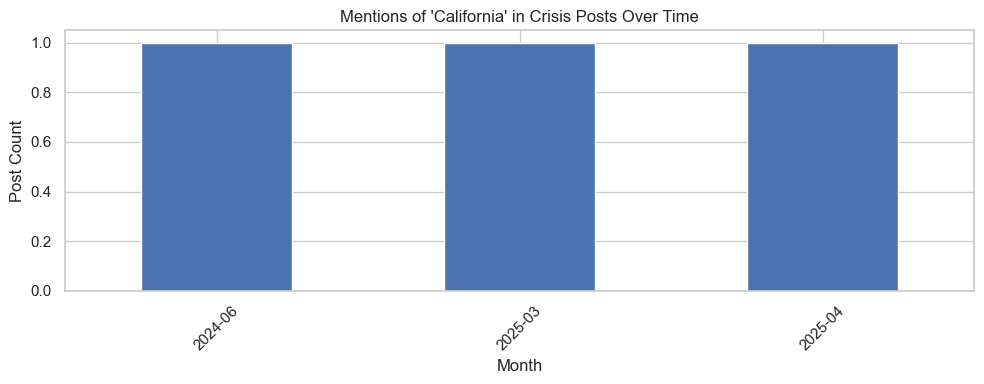

In [245]:
# Monthly Mentions of "California"

df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'], errors='coerce')

# Extract monthly period from timestamp
df_posts['post_month'] = df_posts['timestamp'].dt.to_period('M')

# Flag posts mentioning "California" (case-insensitive, safe for NaNs)
df_posts['mentions_california'] = df_posts['content'].str.contains("california", case=False, na=False)

# Filter for High/Moderate Concern AND mentioning California
geo_time = df_posts[
    (df_posts['risk_level'].isin(['High Concern', 'Moderate Concern'])) &
    (df_posts['mentions_california'])
]

# Count mentions by month
monthly_mentions = geo_time.groupby('post_month').size()

# Plot the result
monthly_mentions.plot(kind='bar', figsize=(10, 4))
plt.title("Mentions of 'California' in Crisis Posts Over Time")
plt.xlabel("Month")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Track volume and intensity of crisis mentions over time, to anticipate spikes or detect emerging events.
- Plot weekly/monthly post count trend 
- Overlay risk levels (high/moderate)
- Plot sentiment over time

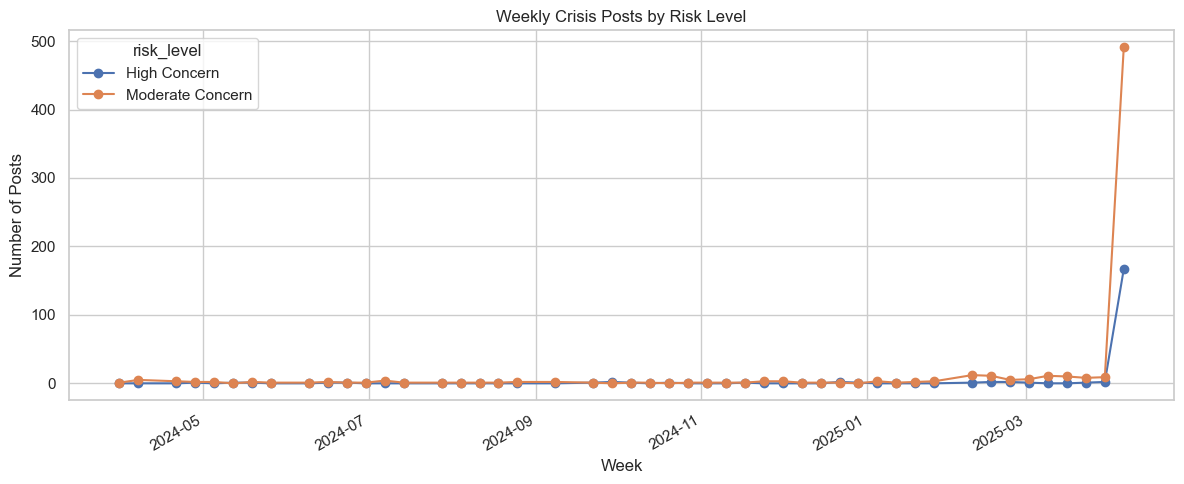

In [223]:
# Crisis risk over time
trend_by_risk = (
    filtered_df.groupby([pd.Grouper(key='timestamp', freq='W'), 'risk_level'])
    .size()
    .unstack(fill_value=0)
)

trend_by_risk.plot(figsize=(12, 5), marker='o')
plt.title("Weekly Crisis Posts by Risk Level")
plt.xlabel("Week")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.tight_layout()
plt.show()


Geospatial Heatmaps with Temporal Filtering - Visualize location-based distress, optionally filtered by recent time windows.
- Identify emerging hotspots where high concern posts are increasing.
- Detect places where crisis posts are growing fast
- Generate a new heatmap every week
- Track changes in geo-intensity

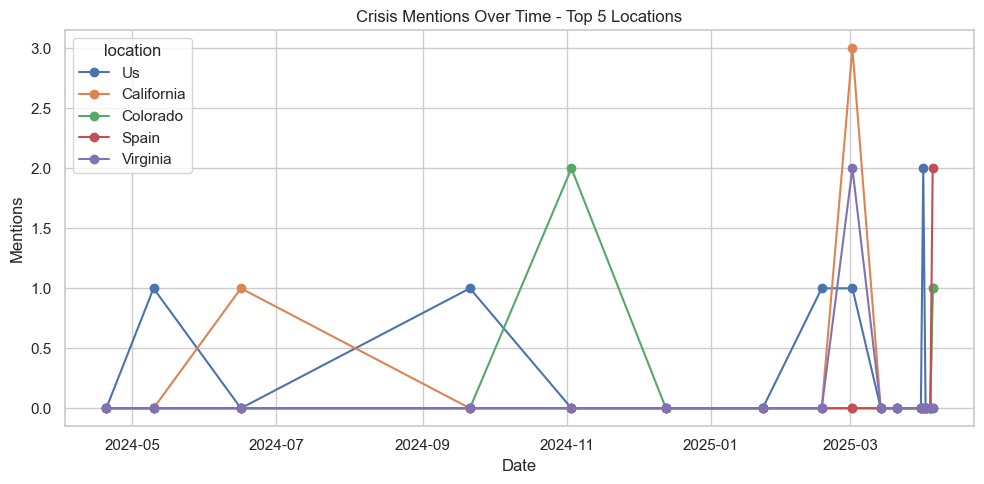

In [233]:
# Combine Time + Location
df_time_loc = pd.DataFrame(location_time_pairs, columns=['date', 'location'])
time_loc_counts = df_time_loc.groupby(['date', 'location']).size().unstack(fill_value=0)

# Plot top 5 locations across time
top_locations = time_loc_counts.sum().sort_values(ascending=False).head(5).index
time_loc_counts[top_locations].plot(figsize=(10, 5), marker='o')
plt.title("Crisis Mentions Over Time - Top 5 Locations")
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.grid(True)
plt.tight_layout()
plt.savefig("top_locations_over_time.png")
plt.show()